# NLP: JAX Machine Translation

In [1]:
## adapted from https://keras.io/examples/nlp/neural_machine_translation_with_transformer/, which is itself an adaptation from https://www.manning.com/books/deep-learning-with-python-second-edition

In [2]:
import os

import pathlib
import random
import string
import re
import numpy as np

import jax
import jax.numpy as jnp
import optax

from flax import nnx

import tiktoken

## Pull down data to temp and extract into memory

There are lots of ways to get this done, but for simplicity and clear visibility into what's happening this is downloaded to a temporary directory, extracted there, and read into a python object with processing.

In [3]:
import requests
import zipfile
import tempfile

url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"

with tempfile.TemporaryDirectory() as temp_dir:
    temp_path = pathlib.Path(temp_dir)
    zip_file_path = temp_path / "spa-eng.zip"

    response = requests.get(url)
    zip_file_path.write_bytes(response.content)

    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(temp_path)

    text_file = temp_path / "spa-eng" / "spa.txt"

    with open(text_file) as f:
        lines = f.read().split("\n")[:-1]
    text_pairs = []
    for line in lines:
        eng, spa = line.split("\t")
        spa = "[start] " + spa + " [end]"
        text_pairs.append((eng, spa))

## Build train/validate/test pair sets
We'll stay close to the original tutorial so it's clear how to follow what's the same vs what's different; one early difference is the choice to go with an off-the-shelf encoder/tokenizer in tiktoken. Specifically "cl100k_base" - it has a wide range of language understanding and it's fast.

In [4]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [5]:
tokenizer = tiktoken.get_encoding("cl100k_base")

We strip out puctuation to keep things simple and in line with the original tutorial - the `[` `]` are kept in so that our `[start]` and `[end]` formatting is preserved.

In [6]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = tokenizer.n_vocab
sequence_length = 20

In [7]:
def custom_standardization(input_string):
    lowercase = input_string.lower()
    return re.sub(f"[{re.escape(strip_chars)}]", "", lowercase)

In [8]:
def tokenize_and_pad(text, tokenizer, max_length):
    tokens = tokenizer.encode(text)[:max_length]
    padded = tokens + [0] * (max_length - len(tokens)) if len(tokens) < max_length else tokens ##assumes list-like - (https://github.com/openai/tiktoken/blob/main/tiktoken/core.py#L81 current tiktoken out)
    return padded

In [9]:
def format_dataset(eng, spa, tokenizer, sequence_length):
    eng = custom_standardization(eng)
    spa = custom_standardization(spa)
    eng = tokenize_and_pad(eng, tokenizer, sequence_length)
    spa = tokenize_and_pad(spa, tokenizer, sequence_length)
    return {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:-1],
            "target_output": spa[1:],
            }

In [10]:
train_data = [format_dataset(eng, spa, tokenizer, sequence_length) for eng, spa in train_pairs]
val_data = [format_dataset(eng, spa, tokenizer, sequence_length) for eng, spa in val_pairs]
test_data = [format_dataset(eng, spa, tokenizer, sequence_length) for eng, spa in test_pairs]

At this point we've extracted the data, applied formatting, and tokenized the phrases with padding. The data is kept in train/validate/test sets that each have dictionary entries, which look like the following:

In [11]:
## data selection example
print(train_data[135])

{'encoder_inputs': [9514, 265, 3339, 264, 2466, 16930, 1618, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'decoder_inputs': [29563, 60, 1826, 7206, 71086, 37116, 653, 16109, 1493, 54189, 510, 408, 60, 0, 0, 0, 0, 0, 0], 'target_output': [60, 1826, 7206, 71086, 37116, 653, 16109, 1493, 54189, 510, 408, 60, 0, 0, 0, 0, 0, 0, 0]}


## Define Transformer components: Encoder, Decoder, Positional Embed

In many ways this is very similar to the original source, with `ops` changing to `jnp` and `keras` or `layers` becoming `nnx`. Certain module-specific arguments come and go, like the rngs attached to most things in the updated version, and decode=False in the MHA call.

In [12]:
class TransformerEncoder(nnx.Module):
    def __init__(self, embed_dim: int, dense_dim: int, num_heads: int, rngs: nnx.Rngs, **kwargs):
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention = nnx.MultiHeadAttention(num_heads=num_heads,
                                          in_features=embed_dim,
                                          decode=False,
                                          rngs=rngs) 
        self.dense_proj = nnx.Sequential(
            *[
                nnx.Linear(embed_dim, dense_dim, rngs=rngs),
                nnx.relu,
                nnx.Linear(dense_dim, embed_dim, rngs=rngs),
            ]
        )
        
        self.layernorm_1 = nnx.LayerNorm(embed_dim, rngs=rngs)
        self.layernorm_2 = nnx.LayerNorm(embed_dim, rngs=rngs)

    def __call__(self, inputs, mask=None):
        if mask is not None:
            padding_mask = jnp.expand_dims(mask, axis=1).astype(jnp.int32)
        else:
            padding_mask = None

        attention_output = self.attention(
            inputs_q = inputs, inputs_k = inputs, inputs_v = inputs, mask=padding_mask, decode = False
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(nnx.Module):
    def __init__(self, sequence_length: int, vocab_size: int, embed_dim: int, rngs: nnx.Rngs, **kwargs):
        self.token_embeddings = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, rngs=rngs)
        self.position_embeddings = nnx.Embed(num_embeddings=sequence_length, features=embed_dim, rngs=rngs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def __call__(self, inputs):
        length = inputs.shape[1]
        positions = jnp.arange(0, length)[None, :]
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return jnp.not_equal(inputs, 0)

class TransformerDecoder(nnx.Module):
    def __init__(self, embed_dim: int, latent_dim: int, num_heads: int, rngs: nnx.Rngs, **kwargs):
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = nnx.MultiHeadAttention(num_heads=num_heads,
                                  in_features=embed_dim,
                                  decode=False,
                                  rngs=rngs)
        self.attention_2 = nnx.MultiHeadAttention(num_heads=num_heads,
                                  in_features=embed_dim,
                                  decode=False,
                                  rngs=rngs)

        self.dense_proj = nnx.Sequential(
            *[
                nnx.Linear(embed_dim, latent_dim, rngs=rngs),
                nnx.relu,
                nnx.Linear(latent_dim, embed_dim, rngs=rngs),
            ]
        )
        self.layernorm_1 = nnx.LayerNorm(embed_dim, rngs=rngs) ## check inputs
        self.layernorm_2 = nnx.LayerNorm(embed_dim, rngs=rngs)
        self.layernorm_3 = nnx.LayerNorm(embed_dim, rngs=rngs)

    def __call__(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs.shape[1])
        if mask is not None:
            padding_mask = jnp.expand_dims(mask, axis=1).astype(jnp.int32)
            padding_mask = jnp.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None
        attention_output_1 = self.attention_1(
            inputs_q=inputs, inputs_v=inputs, inputs_k=inputs,  mask=causal_mask  ## check kwargs, specifically qkv
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2( ## https://github.com/google/flax/blob/main/flax/nnx/nn/attention.py#L403-L405
            inputs_q=out_1,
            inputs_v=encoder_outputs,
            inputs_k=encoder_outputs,
            mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, sequence_length):
        i = jnp.arange(sequence_length)[:, None]
        j = jnp.arange(sequence_length)
        mask = (i >= j).astype(jnp.int32)
        mask = jnp.reshape(mask, (1, 1, sequence_length, sequence_length))
        return mask

## Build out Data Loader, Model and Training Definitions
It can be more computationally efficient to use pygrain for the data load stage, but this way it's abundandtly clear what's happening: data pairs go in and sets of jnp arrays come out, in step with our original dictionaries. 'Encoder_inputs', 'decoder_inputs' and 'target_output'.

In [13]:
class DataLoader:
    def __init__(self, data, batch_size):
        self.data = data
        self.batch_size = batch_size
        self.num_batches = len(data) // batch_size

    def __iter__(self):
        for i in range(self.num_batches):
            batch = self.data[i * self.batch_size: (i + 1) * self.batch_size]
            encoder_inputs = [item["encoder_inputs"] for item in batch]
            decoder_inputs = [item["decoder_inputs"] for item in batch]
            target_output = [item["target_output"] for item in batch]
            yield (jnp.array(encoder_inputs), jnp.array(decoder_inputs), jnp.array(target_output))

Here we finally use our earlier encoder, decoder, and positional embed classes to construct the Model that we'll train and later use for inference.

In [14]:
class TransformerModel(nnx.Module):
    def __init__(self, sequence_length: int, vocab_size: int, embed_dim: int, latent_dim: int, num_heads: int, dropout_rate: float, rngs: nnx.Rngs):
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        self.encoder = TransformerEncoder(embed_dim, latent_dim, num_heads, rngs=rngs)
        self.positional_embedding = PositionalEmbedding(sequence_length, vocab_size, embed_dim, rngs=rngs)
        self.decoder = TransformerDecoder(embed_dim, latent_dim, num_heads, rngs=rngs)
        self.dropout = nnx.Dropout(rate=dropout_rate, rngs=rngs)
        self.dense = nnx.Linear(embed_dim, vocab_size, rngs=rngs)

    def __call__(self, encoder_inputs: jnp.array, decoder_inputs: jnp.array, mask: jnp.array = None, deterministic: bool = False):
        x = self.positional_embedding(encoder_inputs)
        encoder_outputs = self.encoder(x, mask=mask)
        
        x = self.positional_embedding(decoder_inputs)
        decoder_outputs = self.decoder(x, encoder_outputs, mask=mask)
        # per nnx.Dropout - disable (deterministic=True) for eval, keep (False) for training
        decoder_outputs = self.dropout(decoder_outputs, deterministic=deterministic)

        logits = self.dense(decoder_outputs)
        return logits

Optax doesn't have the identical loss function that the source tutorial uses, but this softmax cross entropy works well here - you can one_hot_encode if you don't use the `_with_integer_labels` version of the loss.

In [15]:
def compute_loss(logits, labels):
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=labels)
    return jnp.mean(loss)

While in the original tutorial most of the model and training details happen inside keras, me make them explicit here in our step functions, which are later used in `train_one_epoch` and `eval_model`.

In [16]:
@nnx.jit
def train_step(model, optimizer, batch):
    def loss_fn(model, train_encoder_input, train_decoder_input, train_target_input):
        logits = model(train_encoder_input, train_decoder_input)
        loss = compute_loss(logits, train_target_input)
        return loss

    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, batch[0], batch[1], batch[2])
    optimizer.update(grads)
    return loss

@nnx.jit
def eval_step(model, batch, eval_metrics):
    logits = model(batch[0], batch[1])
    loss = compute_loss(logits, batch[2])
    labels = batch[2]

    eval_metrics.update(
        loss=loss,
        logits=logits,
        labels=labels,
    )    

Here, nnx.MultiMetric helps us keep track of general training statistics, while we make our own dictionaries to hold historical values

In [17]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
}

In [18]:
## Hyperparameters
rng = nnx.Rngs(0)
embed_dim = 256
latent_dim = 2048
num_heads = 8
dropout_rate = 0.5
vocab_size = tokenizer.n_vocab
sequence_length = 20
batch_size = 256
learning_rate = 1e-3
momentum = 0.9
num_epochs = 30

In [19]:
import tqdm

bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
train_total_steps = len(train_data) // batch_size


def train_one_epoch(epoch):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_loader:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics

    eval_metrics.reset()  # Reset the eval metrics
    for val_batch in val_loader:
        eval_step(model, val_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[test] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")

In [20]:
model = TransformerModel(sequence_length, vocab_size, embed_dim, latent_dim, num_heads, dropout_rate, rngs=rng)
optimizer = nnx.Optimizer(model, optax.adam(learning_rate, momentum))

train_loader = DataLoader(train_data, batch_size)
val_loader = DataLoader(val_data, batch_size)
test_loader = DataLoader(test_data, batch_size)

## Start the Training!
With our data loaders set and the model, optimizer, and epoch train/eval functions set up - time to finally press go - on a 3090, this is roughly 19GB VRAM and each epoch is roughly 25 seconds with batch_size set to 256.

In [21]:
for epoch in range(num_epochs):
    train_one_epoch(epoch)
    evaluate_model(epoch)

[train] epoch: 0/30, [325/325], loss=1.5 [00:34<00:00] 


[test] epoch: 1/30
- total loss: 1.5372
- Accuracy: 0.7465


[train] epoch: 1/30, [325/325], loss=0.975 [00:25<00:00]


[test] epoch: 2/30
- total loss: 1.1067
- Accuracy: 0.8040


[train] epoch: 2/30, [325/325], loss=0.763 [00:25<00:00]


[test] epoch: 3/30
- total loss: 0.9740
- Accuracy: 0.8232


[train] epoch: 3/30, [325/325], loss=0.625 [00:25<00:00]


[test] epoch: 4/30
- total loss: 0.9252
- Accuracy: 0.8322


[train] epoch: 4/30, [325/325], loss=0.541 [00:25<00:00]


[test] epoch: 5/30
- total loss: 0.9016
- Accuracy: 0.8372


[train] epoch: 5/30, [325/325], loss=0.493 [00:25<00:00]


[test] epoch: 6/30
- total loss: 0.9002
- Accuracy: 0.8403


[train] epoch: 6/30, [325/325], loss=0.419 [00:25<00:00]


[test] epoch: 7/30
- total loss: 0.9047
- Accuracy: 0.8412


[train] epoch: 7/30, [325/325], loss=0.39 [00:25<00:00] 


[test] epoch: 8/30
- total loss: 0.9118
- Accuracy: 0.8426


[train] epoch: 8/30, [325/325], loss=0.339 [00:25<00:00]


[test] epoch: 9/30
- total loss: 0.9216
- Accuracy: 0.8441


[train] epoch: 9/30, [325/325], loss=0.317 [00:25<00:00]


[test] epoch: 10/30
- total loss: 0.9347
- Accuracy: 0.8444


[train] epoch: 10/30, [325/325], loss=0.299 [00:25<00:00]


[test] epoch: 11/30
- total loss: 0.9699
- Accuracy: 0.8438


[train] epoch: 11/30, [325/325], loss=0.278 [00:25<00:00]


[test] epoch: 12/30
- total loss: 0.9727
- Accuracy: 0.8459


[train] epoch: 12/30, [325/325], loss=0.258 [00:25<00:00]


[test] epoch: 13/30
- total loss: 0.9894
- Accuracy: 0.8463


[train] epoch: 13/30, [325/325], loss=0.242 [00:25<00:00]


[test] epoch: 14/30
- total loss: 1.0019
- Accuracy: 0.8460


[train] epoch: 14/30, [325/325], loss=0.227 [00:25<00:00]


[test] epoch: 15/30
- total loss: 1.0252
- Accuracy: 0.8453


[train] epoch: 15/30, [325/325], loss=0.21 [00:25<00:00] 


[test] epoch: 16/30
- total loss: 1.0493
- Accuracy: 0.8450


[train] epoch: 16/30, [325/325], loss=0.21 [00:25<00:00] 


[test] epoch: 17/30
- total loss: 1.0579
- Accuracy: 0.8473


[train] epoch: 17/30, [325/325], loss=0.194 [00:25<00:00]


[test] epoch: 18/30
- total loss: 1.0818
- Accuracy: 0.8462


[train] epoch: 18/30, [325/325], loss=0.174 [00:25<00:00]


[test] epoch: 19/30
- total loss: 1.0935
- Accuracy: 0.8471


[train] epoch: 19/30, [325/325], loss=0.191 [00:25<00:00]


[test] epoch: 20/30
- total loss: 1.1114
- Accuracy: 0.8469


[train] epoch: 20/30, [325/325], loss=0.173 [00:25<00:00]


[test] epoch: 21/30
- total loss: 1.1276
- Accuracy: 0.8478


[train] epoch: 21/30, [325/325], loss=0.169 [00:25<00:00]


[test] epoch: 22/30
- total loss: 1.1431
- Accuracy: 0.8474


[train] epoch: 22/30, [325/325], loss=0.149 [00:25<00:00]


[test] epoch: 23/30
- total loss: 1.1375
- Accuracy: 0.8473


[train] epoch: 23/30, [325/325], loss=0.152 [00:25<00:00]


[test] epoch: 24/30
- total loss: 1.1580
- Accuracy: 0.8450


[train] epoch: 24/30, [325/325], loss=0.136 [00:25<00:00]


[test] epoch: 25/30
- total loss: 1.1755
- Accuracy: 0.8465


[train] epoch: 25/30, [325/325], loss=0.142 [00:25<00:00]


[test] epoch: 26/30
- total loss: 1.1788
- Accuracy: 0.8464


[train] epoch: 26/30, [325/325], loss=0.131 [00:25<00:00]


[test] epoch: 27/30
- total loss: 1.1899
- Accuracy: 0.8486


[train] epoch: 27/30, [325/325], loss=0.141 [00:25<00:00]


[test] epoch: 28/30
- total loss: 1.1999
- Accuracy: 0.8482


[train] epoch: 28/30, [325/325], loss=0.126 [00:25<00:00]


[test] epoch: 29/30
- total loss: 1.2169
- Accuracy: 0.8473


[train] epoch: 29/30, [325/325], loss=0.116 [00:25<00:00]


[test] epoch: 30/30
- total loss: 1.2074
- Accuracy: 0.8476


We can then plot the loss over training time. That log-plot comes in handy here, or it's hard to appreciate the progress after 1000 steps or so.

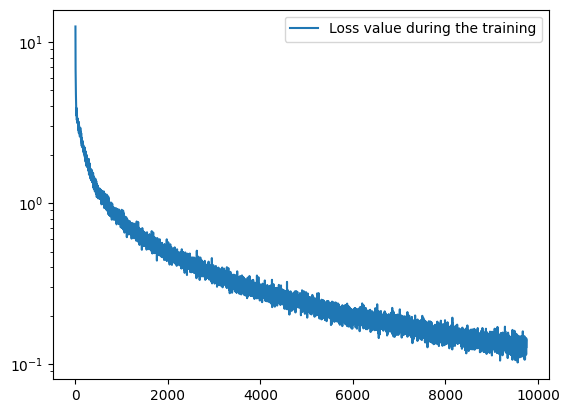

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.yscale('log')
plt.legend()

And eval set Loss and Accuracy - Accuracy does continue to rise, though it's hard-earned progress.

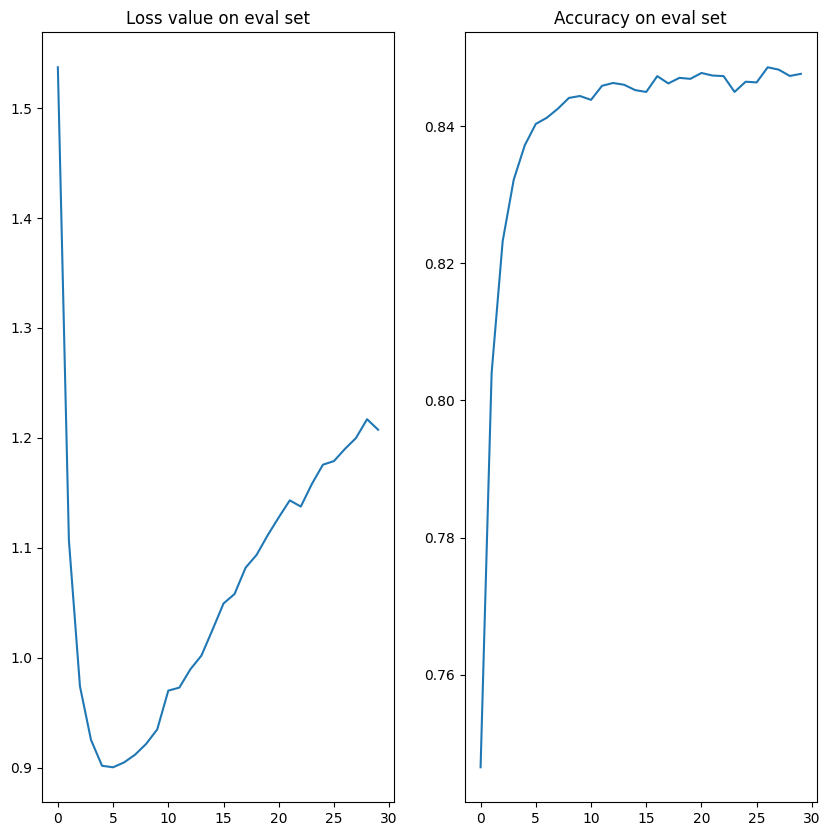

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Loss value on eval set")
axs[0].plot(eval_metrics_history["test_loss"])
axs[1].set_title("Accuracy on eval set")
axs[1].plot(eval_metrics_history["test_accuracy"])

## Use Model for Inference
After all that, the product of what we were working for: a trained model we can save and load for inference. For people using LLMs recently, this pattern may look rather familiar: an input sentence tokenized into an array and computed 'next' token-by-token. While many recent LLMs are decoder-only, this was an encoder/decoder architecture with the very specific english-to-spanish pattern baked in.

We've changed a couple things from the source 'use' function, here - because of the tokenizer used, things like `[start]` and `[end]` are no longer single tokens - instead `[start]` is `[29563, 60] = "[start" + "]"` and `[end]` is `[58308, 60] = "[end" + "]"` - thus we start with only a single token `[start` and can't only test on `last_token = "[end"]`. Otherwise, the main change here is that the input is assumed a single sentence, rather than batch inference.

In [29]:
def decode_sequence(input_sentence):

    input_sentence = custom_standardization(input_sentence)
    tokenized_input_sentence = tokenize_and_pad(input_sentence, tokenizer, sequence_length)
    
    decoded_sentence = "[start"
    for i in range(sequence_length):
        tokenized_target_sentence = tokenize_and_pad(decoded_sentence, tokenizer, sequence_length)[:-1]
        predictions = model(jnp.array([tokenized_input_sentence]), jnp.array([tokenized_target_sentence]))

        sampled_token_index = np.argmax(predictions[0,i, :]).item(0)
        sampled_token = tokenizer.decode([sampled_token_index])
        decoded_sentence += "" + sampled_token

        if decoded_sentence[-5:] == "[end]":
            break
    return decoded_sentence

In [30]:
test_eng_texts = [pair[0] for pair in test_pairs]

In [33]:
test_result_pairs = []
for _ in range(10):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    
    test_result_pairs.append(f"[Input]: {input_sentence} [Translation]: {translated}") 

## Test Results
For the model and the data, not too shabby - It's definitely spanish-ish. Though when 'making' friends, please don't confuse 'hacer' (to make) with 'comer' (to eat).

In [34]:
for i in test_result_pairs:
    print(i)

[Input]: We're going to have a baby. [Translation]: [start] nosotros vamos a tener un bebé [end]
[Input]: You drive too fast. [Translation]: [start] conducís demasiado rápido [end]
[Input]: Let me know if there's anything I can do. [Translation]: [start] déjame saber si hay cualquier cosa que yo pueda hacer [end]
[Input]: Let's go to the kitchen. [Translation]: [start] vayamos a la cocina [end]
[Input]: Tom gasped. [Translation]: [start] tom se quedó sin aliento [end]
[Input]: I was just hanging out with some of my friends. [Translation]: [start] estaba escquieto con algunos de mi amigos [end]
[Input]: Tom is in the bathroom. [Translation]: [start] tom está en el cuarto de baño [end]
[Input]: I feel safe here. [Translation]: [start] me siento segura [end]
[Input]: I'm going to need you later. [Translation]: [start] me voy a necesitar después [end]
[Input]: A party is a good place to make friends with other people. [Translation]: [start] una fiesta es un buen lugar de comer amigos con o